# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [14]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


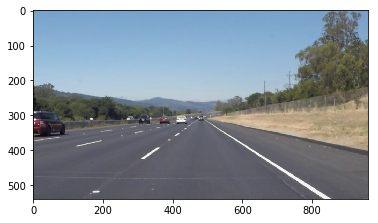

In [15]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [16]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).......  
       
    '''
 
    ''' this code is from yesterday Sunday and I might comebacj to it, it attempts to take the highes up the screen points 
    on either side and connect them to the lowest which is does but its not great'''
    """
    # This is heavily based on the youtube recorded tutorial 
    #slopes and centers        
    rm = [] # should I put in intialisation?
    lm = []
    rc = []
    lc = []
    # steps through lines and gets a slope and center for each
    # slope greater than one left side less than one right side
    for line in lines:
        for x1,y1,x2,y2 in line:
            color=[255, 0, 0]
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)           
            slope  = (y2-y1) / (x2-x1)#had this wrong oops slope  = (x2-x1) / (y2-y1)#iterate between each point
            center = [ (x2+x1)/ 2 , (y2+y1) / 2 ] #calculate slopes and centers
            if slope > 0.5 and slope < 4 : # and slope < 5   :
                lm.append(slope) 
               # print ("Slope Left side ", slope)
                lc.append(center)
            elif slope < -0.5 and slope > -4:# and slope < -1: #and new
                rm.append(slope) # this should ignore slope==0
               # print ("Slope Right side ", slope)#investiage distortion in slope turned out I had the slope formula upside down!
                rc.append(center)
            
    
    # separte left from right by measuring slope throwing out vertical slope
    r_slope=np.sum(rm)/len(rm)
    l_slope=np.sum(lm)/len(lm)  # note to self....how do I throw out exptreme value ?? 
   
    r_center=np.divide(np.sum(rc,axis=0),len(rc))
    l_center=np.divide(np.sum(lc,axis=0),len(lc))
   
    #below formula from video, that what I based the next section on
    #r_center[1] -  np.size(img,0) = r_slope (r_center[0] - x') # assuming y will be half the image height
    yMiddle = int( np.size(img,0)*0.6)  # 0.5 was too high
    yBottom = int(np.size(img,0))    
    xMiddle = int ( ( r_slope * r_center[0] - r_center[1] + yMiddle )/ r_slope )
    xBottom = int (  ( r_slope * r_center[0] - r_center[1] + yBottom )/ r_slope    )
    
    color=[0,255, 0]
    thickness=10
    cv2.line(img, (xMiddle, yMiddle), (xBottom, yBottom), color, thickness) #gave error floats when int needed
   
    
    ##now same for right side
    yMiddleRight = int( np.size(img,0)*0.6)  # 0.5 was too high
    yBottomRight = int(np.size(img,0))    
   
    xMiddleRight = int( ( l_slope * l_center[0] - l_center[1] + yMiddleRight )/ l_slope )
    xBottomRight = int( ( l_slope * l_center[0] - l_center[1] + yBottomRight )/ l_slope )
    
    color=[0,0, 255]
    thickness=10
    cv2.line(img, (xMiddleRight, yMiddleRight), (xBottomRight, yBottomRight), color, thickness)
                
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
   
    #going to try not going to draw lines if no hough lines found
   # if len(lines) > 0 :    draw_lines(line_img, lines)
    draw_lines(line_img, lines)
    
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

In [17]:

def draft_draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    This is a version of draw lines that contains many experiments and ideas 
    They are shown separately here in a function that is not used just so you can see what I tried
    """
    """
    #####################################################################################################
    ATTEMPT: JOINING ENDPOINTS
    OUTPUTS IN ZIP FILE: joining_endpoints_video and joining_endpoints_video
    #####################################################################################################
    """
    
    ##First I tired something that I thought would be simpler than the video suggestion....turned out not to be
    ## my thinking was can I connect the end of one line to the start of the next 
    ## and there by make a continuious line, with some curve?
    ## also this would not in slopes in the same way as you tube tutorial, 
    ## maybe a problem to sort out left and right side lines
    ## I keep track of the previuos x,y of a point to try to connect it to the previuos point
    ## connect start of new line to end of old one , maybe different colour?? to show    
    ## Used a print to make more sense of the points
    ## count = 0 this was to see exactly how many lines I was dealing with 40+ wow!
    ## a couple of problems became clear , there are many lines in a random
    ## order so connecting one to the next does not produce good results
    ##
    ## My conclusion was I had assumed the lines in the line array were in some kind of order 
    ## and the first would connect well to the second but after printing it out that proved untrue
    """
    previousX2Right = 0
    previousY2Right = 0
    previousX2Left = 0
    previousY2Left = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            color=[255, 0, 0]
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            print("X1: " , x1, " y1: ",y1, " x2 ",x2, "y2", y2 ," Slope: ", (y2-y1) / (x2-x1))
            # putting the lines and slopes on the screen is really helping
            if ( (y2-y1) / (x2-x1) ) > 0  : #positve slope => left side #slope zero ignored
                color=[0, 255, 0]
                # print("PreviuosLeftX ", previousX2Left )
                cv2.line(img, (previousX2Left,previousY2Left), (x2, y2), color, thickness)   
                previousX2Left = x2        
                previuosY2Left = y2
            elif ( (y2-y1) / (x2-x1) ) < 0 : #negative slope => right side
                color=[0, 0, 255]
                cv2.line(img, (previousX2Right,previousY2Right), (x1, y1), color, thickness) 
                previousX2Right = x2
                previuosY2Right = y2
    """
    """
    #####################################################################################################
    ATTEMPT: CONNECTING HIGHEST POINT TO LOWEST POINT LEFT AND RIGHT SIDE
    OUTPUTS IN ZIP:  Highest_lowest_point  [video], Highest_point_lowest_point_image ,
            first_ROI_low_high [video] , highest_point_lowest_point_challenge_image
    ####################################################################################################
    """

    """   
    This attempt used a different approach to simply
    find the highest point and the lowest on each side and to draw a line between them
    It attempts to take the highes up the screen points 
    on either side and connect them to the lowest which is does but its not great
    Out3highest_lowest video shows not bad result
     """
  
    """
    highestXLeft = 0
    highestYLeft = 0
    highestXRight = 0
    highestYRight = 0
    lowestXLeft = 500
    lowestYLeft = 500
    lowestXRight = 500
    lowestYRight = 500
    for line in lines:
        for x1,y1,x2,y2 in line:
            color=[255, 0, 0]
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            if ( (y2-y1) / (x2-x1) ) > 0  : #positve slope => left side #slope zero ignored
                if y1<lowestYLeft :
                    lowestYLeft = y1 
                    lowestXLeft = x1   
                if y2<lowestYLeft :
                    lowestYLeft = y2 
                    lowestXLeft = x2
                if y1>highestYLeft :
                    highestYLeft = y1 
                    highestXLeft = x1 
                if y2>highestYLeft :
                    highestYLeft = y2 
                    highestXLeft = x2 
            elif ( (y2-y1) / (x2-x1) ) < 0 : #negative slope => right side
                if y1<lowestYRight :
                    lowestYRight = y1 
                    lowestXRight = x1   
                if y2<lowestYRight :
                    lowestYRight = y2 
                    lowestXRight = x2
                if y1>highestYRight :
                    highestYRight = y1 
                    highestXRight = x1 
                if y2>highestYRight :
                    highestYRight = y2 
                    highestXRight = x2
    color=[0, 255, 0]
    cv2.line(img, (highestXLeft, highestYLeft), (lowestXLeft,lowestYLeft), color, thickness)
    color=[0, 0, 255]
    cv2.line(img, (highestXRight, highestYRight), (lowestXRight,lowestYRight), color, thickness)
    """

    """
    #####################################################################################################
    ATTEMPT: FOLLOWING YOUTUBE VIDEO, AVERAGE CENTER POINT AND AVERAGE SLOPE
    OUTPUT: Challenge , Challange_ROI_marked, Challenge_One_Second
    ####################################################################################################
    """
    
    """
    In this section it is the same as the other drawLines function except,
    there are many attempts to deal with the errors
    The first video Challenge shows the first time I ran this. The ROI was to the left 
    because it was taking its dimensions from the first image called img not the video.
    I was having difficulty seeing why the proportions of the ROI were off so 
    I put the ROI on the video doing no other processing to see it and tweak it hoping that 
    would prevent any difficult lines
    
    Once I was happy with the ROI I commented out the code that put them in and then started to get manyh errors
    
    I tired many things to deal with errors including
    1) "nan" (not a number) error : I used an if statemnt to check for nan and inset a defualt value if it was a nan
    2) IndexError: invalid index to scalar variable.... I put in try statements when a certain line threw 
    this error it would skip the line. But this generate only a few frames and the video does not work.One second video
    3) I also needed to type cast to int using int(variable) several times to change float to int
    4) I tried initalising the center and slope arrays and this stoped on bug but created another. Bascially a type error somewhere else
    6) I also had some if statemnts to clip values above and below certain values to test the idea that extremem values were causeing the problem tbut that did not work 
    7) I inserted variuos print statements left in comment and they were useful to see what was going wrong. 
    I could see it was after a few point this would happen.

    """
    #slopes and centers        
    rm = [] # putting in intialisation....didn't work
    lm = []
    rc = []
    lc = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            color=[255, 0, 0]
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)           
            slope  = (y2-y1) / (x2-x1)#had this worng oops slope  = (x2-x1) / (y2-y1)#iterate between each point
            center = [ (x2+x1)/ 2 , (y2+y1) / 2 ] #calculate slopes and centers
            if slope > 0   :
                lm.append(slope) 
               # print ("Slope Left side ", slope)
                lc.append(center)
            elif slope < 0 : 
                rm.append(slope) # this should ignore slope==0
               # print ("Slope Right side ", slope)#investiage distortion in slope turned out I had the slope formula upside down!
                rc.append(center)
    # average over all slopes to get sinlgle slope and center
    r_slope=np.sum(rm)/len(rm)
    l_slope=np.sum(lm)/len(lm)  # note to self....how do I throw out exptreme value ?? 
    #print("r_slope " , r_slope , " l_slope " , l_slope )
    r_center=np.divide(np.sum(rc,axis=0),len(rc))
    l_center=np.divide(np.sum(lc,axis=0),len(lc))
    #print("r_center " , r_center , " l_center " , l_center )
    # it was useful to print out values here
    # print("r_slope " , r_slope , " l_slope " , l_slope , " r_center " , r_center , "l_center " , l_center )
     
    yMiddle = int( np.size(img,0)*0.6)  # 0.5 was too high
    # int(round(yMiddle)) this didn't work this might h = int(round(h))
    #how about a clip less than 0 or greather than width less than zero or greater than height?
    '''  
    if r_center[0] < 0 : r_center[0] = 0
    if r_center[0] < 700 : r_center[0] = 700
    if r_center[1] < 0 : r_center[1] = 0
    if r_center[1] > 700 : r_center[1] = 700
    
    if l_center[0] < 0 : l_center[0] = 0  # had r here woops
    if l_center[0] < 700 : l_center[0] = 700
    if l_center[1] < 0 : l_center[1] = 0
    if l_center[1] > 700 : l_center[1] = 700
    ''' 
    
    yBottom = int(np.size(img,0))    
    xMiddle = ( r_slope * r_center[0] - r_center[1] + yMiddle )/ r_slope 
    #if math.isnan(xMiddle): #math.isnan(x)
    #    xMiddle = 100
    #else :
    #    xMiddle = int(xMiddle)
    
    xBottom =   ( r_slope * r_center[0] - r_center[1] + yBottom )/ r_slope    
    #if math.isnan(xBottom): #math.isnan(x)
    #    xBottom = 100
    #else :
    #    xBottom = int(xBottom)
    
    color=[0,255, 0]
    thickness=10
   # print("Second time suspected rounding?? r_slope " , r_slope , " l_slope " , l_slope )
    cv2.line(img, (xMiddle, yMiddle), (xBottom, yBottom), color, thickness) #gave error floats when int needed
    #print("yMiddle ", yMiddle , "XMiddle ", xMiddle)
    
    ##now for right side
    yMiddleRight = int( np.size(img,0)*0.6)  # 0.5 was too high
    # int(round(yMiddle)) this didn't work this might h = int(round(h))
    yBottomRight = int(np.size(img,0))    
    # i am putting in a try here becuase this is throwing an error 
    #and I cant fix it so I am going to skip it if it throws an error
    print("l_center[0] : " , l_center[0]) #, "L-center[1] : ", l_center[1])#this causes crash
      #  try:
    xMiddleRight = ( l_slope * l_center[0] - l_center[1] + yMiddleRight )/ l_slope 
      #  except:
      #      xMiddleRight = 100

      #  if math.isnan(xMiddleRight): #math.isnan(x)
      #      xMiddleRight = 100
      #  else :
      #      xMiddleRight = int(xMiddleRight)

      #  try:
    xBottomRight =   ( l_slope * l_center[0] - l_center[1] + yBottomRight )/ l_slope 
      #  except:
      #      xBottomRight = 100



     #   if math.isnan(xBottomRight): #math.isnan(x)
     #       xBottomRight = 100
     #   else:
     #       xBottomRight = int(xBottomRight)
    
    color=[0,0, 255]
    thickness=10
   # print("Second time suspected rounding?? r_slope " , r_slope , " l_slope " , l_slope )
    cv2.line(img, (xMiddleRight, yMiddleRight), (xBottomRight, yBottomRight), color, thickness)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

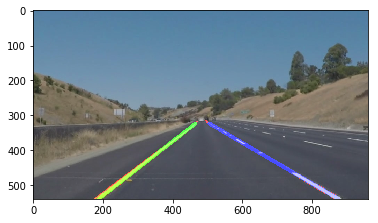

In [18]:
import os
files = os.listdir("test_images/")

for file in files:
    if file[0:6] != "output":
        img = mpimg.imread("test_images/" + file)
        gray = grayscale(img)
        gray = gaussian_blur(gray,3)
        edges = canny(gray,50,150)
        
        imshape = img.shape
        vertices = np.array([[(0.51* imshape[1], imshape[0] * 0.58), 
                              (0.49* imshape[1], imshape[0] * 0.58),
                              (0 , imshape[0]),
                              (imshape[1], imshape[0])]], dtype = np.int32 )
        
        target = region_of_interest(edges, vertices)
        
        lines = hough_lines(target, 1 ,np.pi/180,35,5,2)
        
        result = weighted_img(lines,img,α=0.8, β=1.0)

        plt.imshow(result,cmap = 'gray')
        
        r,g,b = cv2.split(result)
        result = cv2.merge((b,g,r))
        
        cv2.imwrite("test_images/output_" + file, result)

    

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [19]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [20]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def process_image(image): #def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    gray = grayscale(image)
    gray = gaussian_blur(gray,3)
    edges = canny(gray,50,150)
        
    imshape = image.shape
    vertices = np.array([[(0.51* imshape[1], imshape[0] * 0.58) #top right
                          ,(0.49* imshape[1], imshape[0] * 0.58) #top left
                          ,(0 , imshape[0]), #bottom left
                          (imshape[1], imshape[0])]], dtype = np.int32 ) #bottom right
    target = region_of_interest(edges, vertices)
        
    lines = hough_lines(target, 1 ,np.pi/180,35,5,2)
       
    result = weighted_img(lines,image,α=0.8, β=1.0)
    
    return result

def process_image_challenge(image): #def process_image_challenge(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    gray = grayscale(image)
    gray = gaussian_blur(gray,3)
    edges = canny(gray,50,150)
        
    imshape = image.shape###arrgggggg img image
    
    topLeftX     = int(imshape[1] * 0.45)
    topLeftY     = int(imshape[0] * 0.60)
    topRightX    = int(imshape[1] * 0.55)
    topRightY    = int(imshape[0] * 0.60)
    bottomLeftX  = int(imshape[1] * 0.10)
    bottomLeftY  = int(imshape[0] * 0.90) #not sure this is what I am seeing .....img v's image!!
    bottomRightX = int(imshape[1] * 0.90)
    bottomRightY = int(imshape[0] * 0.90)
    
    vertices = np.array([[(topLeftX,topLeftY ) #top right
                          ,(topRightX,topRightY) #top left
                          ,(bottomLeftX,bottomLeftY)
                          ,(bottomRightX,bottomRightY)]], dtype = np.int32 ) #bottom right
  
    #adding draw lines here to draw Region of Interest so I can see it
    '''
    color=[255, 0, 0]
    thickness = 5
    image = cv2.line(image, (topLeftX,topLeftY) , (bottomLeftX,bottomLeftY),color,thickness)
    image = cv2.line(image, (topLeftX,topLeftY) , (topRightX,topRightY),color,thickness)                        
    image = cv2.line(image, (bottomRightX,bottomRightY) , (bottomLeftX,bottomLeftY),color,thickness)
    image = cv2.line(image, (topRightX,topRightY) , (bottomRightX,bottomRightY),color,thickness)
 
    return image
    '''
    target = region_of_interest(edges, vertices)
    #lines = hough_lines(target, 1 ,np.pi/180,35,5,2) # before feedback #img, rho, theta, threshold, min_line_len, max_line_gap)
    lines = hough_lines(target, 2 ,np.pi/180,70,150,150)
    result = weighted_img(lines,image,α=0.8, β=1.0)
    
    
    return result

Let's try the one with the solid white lane on the right first ...

In [22]:
white_output = 'test_videos_output\solidWhiteRight_After_Feedback.mp4'
#white_output = 'solidWhiteRight.mp4'
#white_output = 'output_video\out18.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("solidWhiteRight.mp4").subclip(0,2)
#clip1 = VideoFileClip("test_videos\solidWhiteRight.mp4")
clip1 = VideoFileClip("test_videos\solidWhiteRight.mp4")
#clip1 = VideoFileClip("test_videos\challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
##%time white_clip.write_videofile(white_output, audio=False)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output\solidWhiteRight_After_Feedback.mp4
[MoviePy] Writing video test_videos_output\solidWhiteRight_After_Feedback.mp4


100%|███████████████████████████████████████████████████████████▋| 221/222 [00:06<00:00, 35.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output\solidWhiteRight_After_Feedback.mp4 



Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [24]:
yellow_output = 'test_videos_output/solidYellowLeft_After_Feedback.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft_After_Feedback.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft_After_Feedback.mp4


100%|███████████████████████████████████████████████████████████▉| 681/682 [00:21<00:00, 31.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft_After_Feedback.mp4 

Wall time: 22.7 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [26]:
challenge_output = 'test_videos_output/challenge_write_up_version_After_Feedback.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(7,10)
#clip3 = VideoFileClip('test_videos/challenge.mp4')

challenge_clip = clip3.fl_image(process_image_challenge)
#challenge_clip = clip3.fl_image(process_image)
#challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)
##
## PLEASE NOTE THIS CAUSES A CRASH BUT DOES PROCESS A COUPLE OF SECONDS. AN PUT PUT FILE WILL BE CREATED 
## AND SHOW LANES FOR A COUPLE OF SECONDs
## A SUBCLIP IS USED TO FIND THE SEQUENCE OF VIDEO THAT PRODUCES BEST RESULTS
##

IndexError: invalid index to scalar variable.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))